<a href="https://colab.research.google.com/github/brownian-explorer/securities-master/blob/main/Hurst_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_rs_analysis(time_series):
    n = len(time_series)

    # Calculate the range
    range_vals = np.zeros((n,), dtype=float)
    for i in range(1, n + 1):
        data = time_series[:i]
        mean = np.mean(data)
        deviation = np.cumsum(data - mean)
        range_vals[i - 1] = np.max(deviation) - np.min(deviation)

    # Calculate the standard deviation
    std_dev = np.std(time_series)

    # Calculate the rescaled range
    epsilon = 1e-10
    rescaled_range = np.cumsum(range_vals) / (n * std_dev + epsilon)

    # Fit a linear regression to log-log plot
    log_n = np.log(np.arange(1, n + 1))
    log_r = np.log(rescaled_range)
    slope, _ = np.polyfit(log_n, log_r, 1)

    # Hurst exponent is the slope of the linear regression
    hurst_exponent = slope

    plt.figure(figsize=(8, 6))
    plt.plot(log_n, log_r, label='Log-Log Plot')
    plt.title('R/S Analysis - Log-Log Plot')
    plt.xlabel('Log(Number of Data Points)')
    plt.ylabel('Log(Rescaled Range)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return hurst_exponent


<ipython-input-12-d213d78bb576>:24: RuntimeWarning: divide by zero encountered in log
  log_r = np.log(rescaled_range)


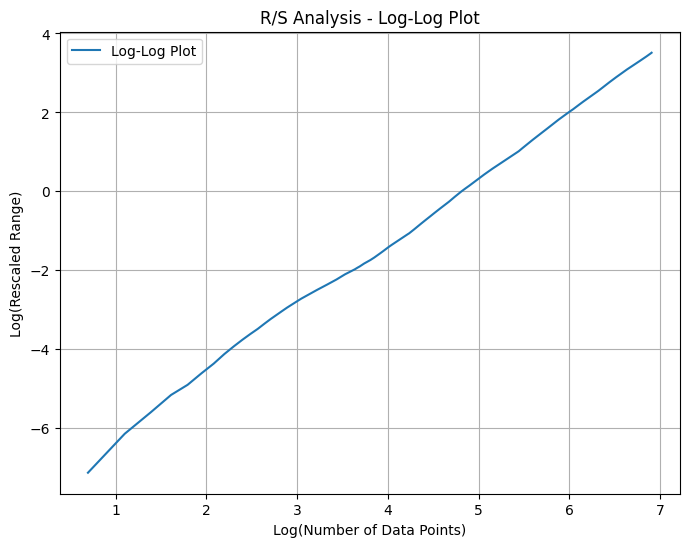

Hurst Exponent: nan


In [13]:
your_time_series_data = np.random.randn(1000)  # Example random time series
hurst = visualize_rs_analysis(your_time_series_data)
print("Hurst Exponent:", hurst)

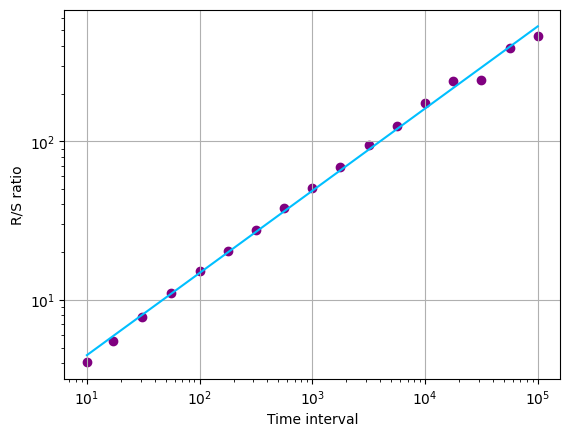

H=0.5183, c=1.3587


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from hurst import compute_Hc, random_walk

# Use random_walk() function or generate a random walk series manually:
# series = random_walk(99999, cumprod=True)
np.random.seed(42)
random_changes = 1. + np.random.randn(99999) / 1000.
series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(series, kind='price', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [33]:
class YahooRetriever:
    def __init__(self):
        self.file_path = "/content/drive/MyDrive/findata/OHLC_yahoo"

    def retrieve_single_ohlc(self, ticker, start_date, end_date):
        start_date = datetime.strptime(start_date, "%d/%m/%Y")
        end_date = datetime.strptime(end_date, "%d/%m/%Y")
        years = range(start_date.year, end_date.year + 1)
        dfs = []
        initial = ticker.split(":")[1][0]

        for year in years:
            file_path = f"{self.file_path}/{initial.upper()}/{ticker.upper()}/{year}.csv"
            try:
                df = pd.read_csv(file_path)
                df['Date'] = pd.to_datetime(df['Date'])  # Assuming the date column is named 'Date'
                mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
                dfs.append(df.loc[mask])
            except FileNotFoundError:
                print(f"File not found for the year {year}")

        if not dfs:
            print("No data found within the specified date range.")
            return None

        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df

    def retrieve_multi_ohlc(self, tickers, start_date, end_date, ohlc):
        ohlc = ohlc[0].upper() + ohlc[1:].lower()
        df = pd.DataFrame()

        for i, ticker in enumerate(tickers):
          ticker = ticker.upper()
          single_data = self.retrieve_single_ohlc(ticker, start_date, end_date)
          if i == 0 and not single_data.empty:
              df["Date"] = single_data["Date"]
              df[ticker] = single_data["Close"]
          elif i > 0 and not single_data.empty:
              df[ticker] = single_data["Close"]
          else:
              print(f"No data found for {ticker}")
              continue
        return df

In [45]:
import pandas as pd
from datetime import datetime

aapl = YahooRetriever()
df = aapl.retrieve_multi_ohlc(["NASDAQ:NVDA"], "01/01/2017", "01/11/2023", "close")

In [46]:
df['DailyReturn'] = df['NASDAQ:NVDA'].pct_change()

# Calculate cumulative product of returns
df['CumulativeReturn'] = (1 + df['DailyReturn']).cumprod()

series = df['CumulativeReturn'].dropna().tolist()

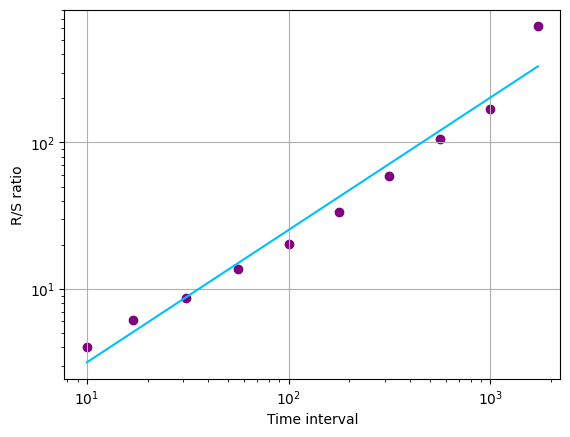

H=0.9037, c=0.3937


In [47]:
# Evaluate Hurst equation
H, c, data = compute_Hc(series, kind='price', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))